In [1]:
import pickle
import pprint
import warnings
from datetime import datetime
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pytz
import seaborn as sns
from omegaconf import OmegaConf
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

from src.config import cfg
from src.dir import create_dir
from src.seed import seed_everything

cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)

warnings.filterwarnings("ignore")


exp_number: '001'
run_time: base
data:
  input_root: ../../data/cmi2
  train_path: ../../data/cmi2/train.csv
  test_path: ../../data/cmi2/test.csv
  sample_submission_path: ../../data/cmi2/sample_submission.csv
  data_dictionary_path: ../../data/cmi2/data_dictionary.csv
  output_root: ../../data/output
  results_root: ../../results
  results_path: ../../results/001/base
seed: 319
n_splits: 5
target: sii
lgb:
  params:
    objective: None
    metric: None
    verbosity: -1
    boosting_type: gbdt
    learning_rate: 0.01
    num_leaves: 16
    min_child_samples: 20
    max_depth: -1
    subsample_freq: 0
    bagging_seed: 0
    feature_fraction: 0.5
    bagging_fraction: 0.9
    reg_alpha: 0.1
    reg_lambda: 0.1
  early_stopping_rounds: 500
  log_evaluation_period: 100
  num_boost_round: 100000



### データの準備

In [2]:
# データの読み込み
train = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
sample_submission = pl.read_csv(cfg.data.sample_submission_path, try_parse_dates=True)

# CV
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)


In [3]:
# sii（target）が欠損している行を削除
train = train.drop_nulls(subset=[cfg.target])
assert train["sii"].null_count() == 0


In [4]:
# 不要な列を削除
train_only_cols = list(set(train.columns) - set(test.columns))

X = train.drop(["id"] + train_only_cols).to_pandas()
y = train[cfg.target].to_pandas()


In [5]:
# カテゴリー列の指定
cat_cols = X.columns[X.dtypes == "object"].to_list()
if cat_cols:
    X[cat_cols] = X[cat_cols].astype("category")


### 学習

In [6]:
# QWKの計算に必要な値を取得
a = y.mean()
b = y.var(ddof=0)

y_min = y.min()
y_max = y.max()


In [7]:
# QWKの実装に必要な関数


def quadratic_weighted_kappa(preds, data):
    y_true = data.get_label()
    y_pred = preds.clip(y_min, y_max).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return "QWK", qwk, True


def qwk_obj(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.clip(y_min, y_max)
    f = 1 / 2 * np.sum((preds - labels) ** 2)
    g = 1 / 2 * np.sum((preds - a) ** 2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df / g - f * dg / g**2) * len(labels)
    hess = np.ones(len(labels))
    return grad, hess


In [8]:
params = dict(cfg.lgb.params)
params["objective"] = qwk_obj

# The initial score of the model is the key parameter.
# I found that the mean value of the target is a bad choice for this data.
init_score = 2.0


In [20]:
# 実験結果格納用のディレクトリを作成
japan_tz = pytz.timezone("Asia/Tokyo")
cfg.run_time = datetime.now(japan_tz).strftime("%Y%m%d_%H%M%S")
create_dir(cfg.data.results_path)

# 学習設定
lgb_data = lgb.Dataset(
    X,
    label=y,
    init_score=[init_score] * len(y),
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation_period),
]

# 学習
cv_results = lgb.cv(
    params=params,
    train_set=lgb_data,
    folds=skf.split(X, y),
    feval=quadratic_weighted_kappa,
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
with open(f"{cfg.data.results_path}/model.pkl", "wb") as f:
    pickle.dump(cvbooster, f)

# # モデルのロード
# with open(f"{cfg.data.results_path}/model.pkl", "rb") as f:
#     loaded_cvbooster = pickle.load(f)


### log


In [13]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid QWK-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid QWK-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_path}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write(f"best_score_stdv: {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

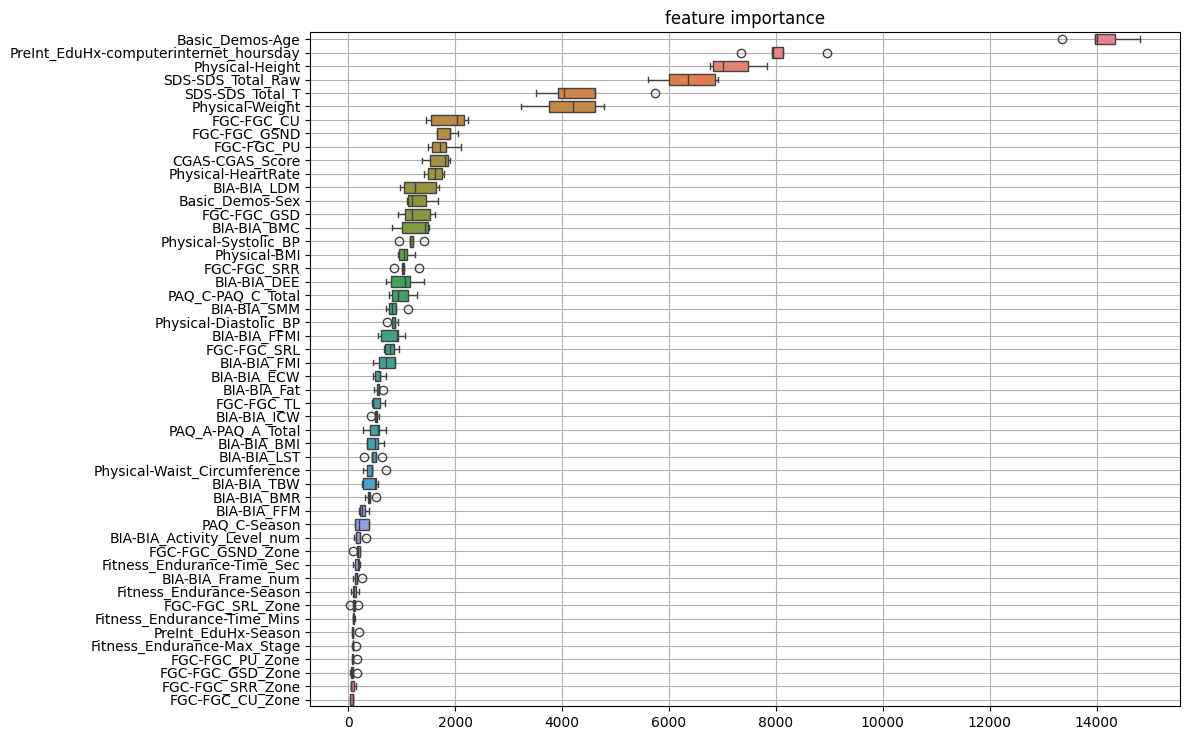

In [14]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_path}/feature_importance.png")


### oof

CV QWK: 0.46654955216525973


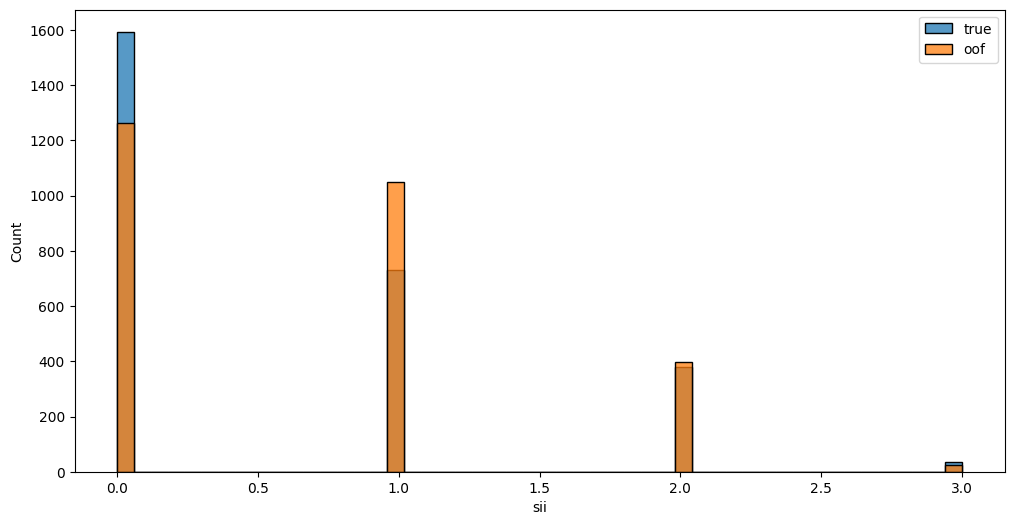

In [27]:
oof = np.zeros(len(train))

# 各foldで推論してoofを作成
for i, (_, val_idx) in enumerate(skf.split(X, y)):
    x_val = X.iloc[val_idx]
    model = cvbooster.boosters[i]
    oof[val_idx] = model.predict(x_val, num_iteration=cvbooster.best_iteration) + init_score # init_scoreを足す

# clip
oof = oof.clip(y_min, y_max).round()
# evaluation
qwk = cohen_kappa_score(y, oof, weights="quadratic")
print(f"CV QWK: {qwk}")

# oofを保存
np.save(f"{cfg.data.results_path}/oof.npy", oof)

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(y, bins=50, ax=ax)
sns.histplot(oof, bins=50, ax=ax)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_path}/oof_hist.png")


### Submission

In [37]:
# 推論
X_test = test.drop("id").to_pandas()
X_test[cat_cols] = X_test[cat_cols].astype("category")
y_preds = cvbooster.predict(X_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0) + init_score
y_pred = y_pred.clip(y_min, y_max).round()

# 提出ファイル作成
sub_df = pl.read_csv(cfg.data.sample_submission_path)
sub_df = sub_df.with_columns(pl.Series(y_pred).alias(cfg.target))
sub_df.write_csv(f"{cfg.data.results_path}/submission.csv")
sub_df.head()


id,sii
str,f64
"""00008ff9""",1.0
"""000fd460""",0.0
"""00105258""",1.0
"""00115b9f""",0.0
"""0016bb22""",1.0
